# ENSF 444 Final Project - California House Price Predictor
### Due: March 28 at 11:59pm

## Group 20 Members - UCID
### Alvin long - 30184369
### Mohamad Ghattas - 30194874
### Tchaka Gashagaza Gisa - 30162495

## Step 1: Import Necessary Libraries
We start by importing essential libraries for data handling, model training, and evaluation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore') #ignoring some deprication warnings

## Step 2: Load the Dataset
We then fetch the California Housing Prices dataset directly from sklearn.datasets.

In [3]:
# Load the California housing dataset
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target  # Median house value

# Display first 5 rows
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Step 3: Data Preprocessing
Next, we check for missing values & basic statistics in our dataset.

In [4]:
# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        target  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mea

As we can observe, the California Housing dataset has no missing values, we can move forward.

## Step 4: Define Features and Target Variable
We then split our dataset into 80% training and 20% testing sets to provide a good balance between proper training and realistic performance for our models.

In [5]:
# Define features and target
X = df.drop(columns=["target"])
y = df["target"]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 5: Apply ColumnTransformer for Preprocessing
Since all features are numerical, we standardize the data using StandardScaler inside a ColumnTransformer, and don't use OneHotEncoder.

In [6]:
# Define numerical features (all features are numerical)
num_features = X.columns

# Define ColumnTransformer with StandardScaler for numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features)  # Apply StandardScaler to numerical columns
    ]
)

## Step 6: Create Pipelines for Different Models
Now we define our three models:

1. Linear Regression (Baseline)

2. Random Forest Regressor (Non-linear)

3. Gradient Boosting Regressor (Non-linear)

In [7]:
# Define model pipelines
linear_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

gb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(n_estimators=100, random_state=42))
])

## Step 7: Train & Evaluate Models
With the pipelines set up, we then train all three models and evaluate them using R² Score and RMSE since this is a regression problem (predicting continuous values).

In [8]:
# Train and evaluate function
def evaluate_model(model_pipeline, X_train, X_test, y_train, y_test):
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Model: {model_pipeline.named_steps['model'].__class__.__name__}")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}\n")

# Evaluate all models
evaluate_model(linear_pipeline, X_train, X_test, y_train, y_test)
evaluate_model(rf_pipeline, X_train, X_test, y_train, y_test)
evaluate_model(gb_pipeline, X_train, X_test, y_train, y_test)

Model: LinearRegression
R² Score: 0.5758
RMSE: 0.7456

Model: RandomForestRegressor
R² Score: 0.8050
RMSE: 0.5055

Model: GradientBoostingRegressor
R² Score: 0.7756
RMSE: 0.5422



## Step 8: Hyperparameter Tuning with GridSearchCV
We then optimize Random Forest and Gradient Boosting using Grid Search Cross Validation. We don't do a Grid Search for Linear Regression since it has no major hyperparameters to tune, unlike Random Forest and Gradient Boosting, which have many hyperparameters (e.g., number of trees, depth, learning rate).

### Grid Search for Random Forest

In [9]:
rf_param_grid = {
    "model__n_estimators": [50, 100, 200], 
    "model__max_depth": [10, 20, None], 
    "model__min_samples_split": [2, 5, 10]
}

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
best_rf_model = rf_grid_search.best_estimator_
evaluate_model(best_rf_model, X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=50; total time=   2.0s
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=50; total time=   2.0s
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=50; total time=   2.0s
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=   4.4s
[CV] END model__max_depth=10, model__min_samples_split=5, model__n_estimators=50; total time=   2.3s
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=   4.3s
[CV] END model__max_depth=10, model__min_samples_split=5, model__n_estimators=50; total time=   2.4s
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=   4.4s
[CV] END model__max_depth=10, model__min_samples_split=5, model__n_estimators=50; total time=   2.0s
[CV] END model__max_depth=1

### Grid Search for Gradient Boosting

In [10]:
gb_param_grid = {
    "model__n_estimators": [50, 100, 200], 
    "model__learning_rate": [0.01, 0.1, 0.2], 
    "model__max_depth": [3, 5, 7]
}

gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2)
gb_grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)
best_gb_model = gb_grid_search.best_estimator_
evaluate_model(best_gb_model, X_train, X_test, y_train, y_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50; total time=   1.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50; total time=   1.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50; total time=   1.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   2.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   2.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   2.3s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=50; total time=   1.8s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=50; total time=   1.8s
[CV] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=50; total time=   1.8s
[CV] END model__learning_rate=0.01, model__ma

## Step 9: Model Performance Visualization
Knowing our best model is Gradient Boosting, we then visualize the actual vs. predicted values of this model.

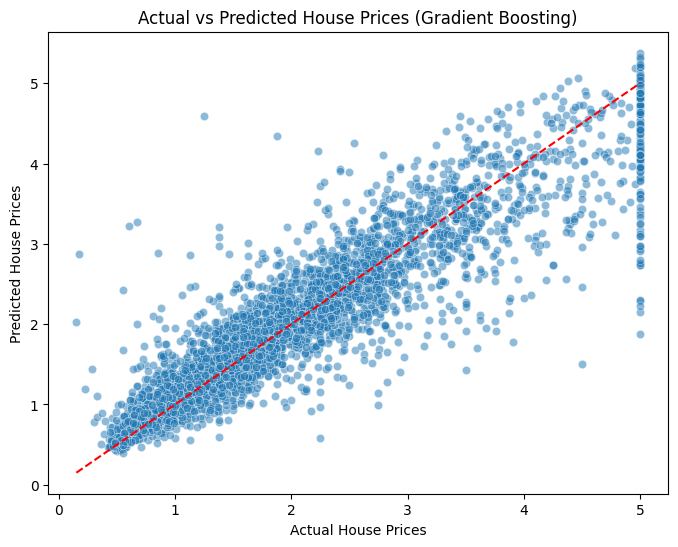

In [11]:
# Predict using the best Gradient Boosting model
y_pred = best_gb_model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red")  # Perfect fit line
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Actual vs Predicted House Prices (Gradient Boosting)")
plt.show()

## Step 10: Feature Importance Analysis
Finally, for extra information, we check the most influential features for the Gradient Boosting model.

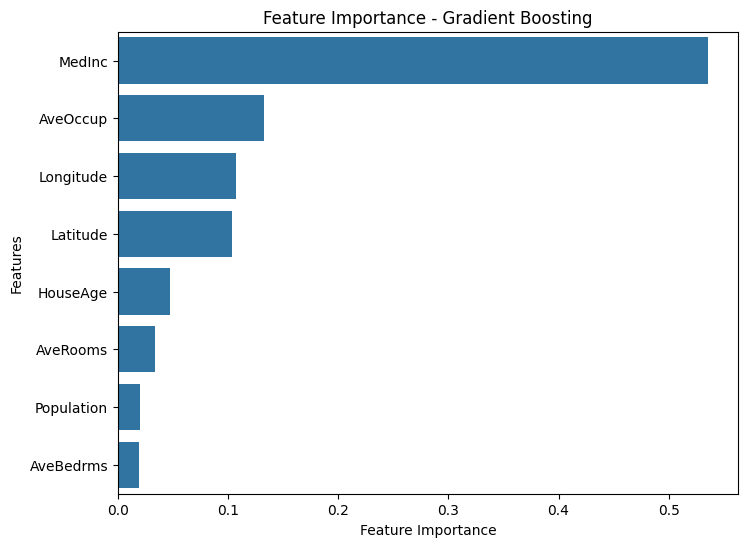

In [12]:
# Get feature importance from the best Gradient Boosting model
feature_importances = best_gb_model.named_steps["model"].feature_importances_

# Convert to DataFrame
importance_df = pd.DataFrame({"Feature": num_features, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance - Gradient Boosting")
plt.show()

## Conclusions

1. Linear Regression serves as a baseline model, with the lowest accuracy (0.5758) and highest root mean squared error (0.7456) values for any model tested.

2. Random Forest is a relatively good classifier for our dataset (R^2=0.8063, RMSE=0.5038), and actually outperforms the Gradient Boosting model before the Grid Search hyperparameter tuning, where it displays marginal improvement compared to the bigger jump made by the other model.

3. Gradient Boosting is our best model after Grid Search hyperparameter tuning, evidenced by the jump in R^2 score from 0.7756 to 0.8420. It also has the lowest RMSE value (0.455).

4. Visualizing the feature importance graph for our best model, it's clear that MedInc (median Income of households) is by far the most important feature in determining the house price. This correlation is predictable since higher median income in a given block also generally means higher property values.